In [6]:
##打开调试日志
import logging
logging.basicConfig(level=logging.INFO,format="%(filename)s[line:%(lineno)d] %(levelname)s %(message)s")
logger=logging.getLogger(__name__)

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
from adversary import Adversary
#from adversarialbox.attacks.saliency import JSMA
from JSMA import JSMA
from LeNet import LeNet
from pytorch import PytorchModel
import numpy as np
import cv2
#from tools import show_images_diff
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

from past.utils import old_div
import d2lzh_pytorch as d2l

In [59]:
def show_images_diff(original_img, original_label, adversarial_img, adversarial_label):
    plt.figure()

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img

    l0 = np.where(difference != 0)[0].shape[0]
    l2 = np.linalg.norm(difference)
    # print(difference)
    print("l0={} l2={}".format(l0, l2))

    # (-1,1)  -> (0,1)
    difference = old_div(difference, abs(difference).max()) / 2.0 + 0.5

    plt.imshow(difference, cmap=plt.cm.blue)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
#定义被攻击的图片
image_path="f:\\cow.jpg"

In [3]:
mnist_train = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)
mnist_test1=torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())
test_loader=torch.utils.data.DataLoader(mnist_test1, batch_size=1, shuffle=False)

In [4]:
X, y = iter(test_iter).next()

tensor([[7, 2, 1, 0, 4, 1, 4, 9],
        [5, 9, 0, 6, 9, 0, 1, 5]])


(1, 28, 28)

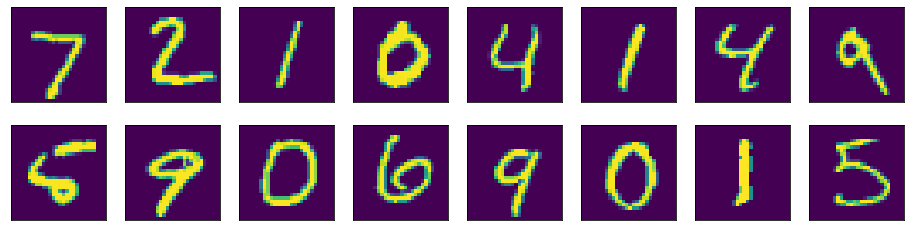

In [28]:
d2l.show_images([i[0] for i in X[:16]],2,8)
print(y[:16].view(-1,8))
#X[0].shape
np.array(X[0]).shape

In [18]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#cv2默认读取格式为bgr bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]
print(orig.shape)
#转换成224*224
orig = cv2.resize(orig, (224, 224))
adv=None
img = orig.copy().astype(np.float32)
img = img.transpose(2, 0, 1)
print(img.shape)

<ipython-input-18-3355f517f2d9>[line:2] INFO CUDA Available: False


(545, 820, 3)
(3, 224, 224)


In [20]:
pretrained_model='lenetc.pth'
model = LeNet().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [38]:

#图像数据标准化
'''
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

#pytorch中图像格式为CHW  
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)
'''
img = Variable(X[0].to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network
#Alexnet
#model = models.alexnet(pretrained=True).to(device).eval()

#print(model)

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)

#实例化JSMA max_iter为最大迭代次数  theta为扰动系数 max_perturbations_per_pixel为单像素最大修改次数
attack = JSMA(m)
attack_config = {
        "max_iter": 2000,
        "theta": 0.3,
        "max_perturbations_per_pixel": 7,
        "fast":True,
        "two_pix":False
}


inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

#定向攻击
tlabel = 0
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)

if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    print('attack failed')


print("jsma attack done")

pytorch.py[line:53] INFO Finish PytorchModel init
base.py[line:65] INFO adversary:
         original_label: 7
         target_label: 0
         is_targeted_attack: True
JSMA.py[line:79] INFO step = 0, original_label = 7, adv_label=7 target logit=-2.67924427986145
JSMA.py[line:79] INFO step = 1, original_label = 7, adv_label=7 target logit=-2.3577404022216797
JSMA.py[line:79] INFO step = 2, original_label = 7, adv_label=7 target logit=-2.110347032546997
JSMA.py[line:79] INFO step = 3, original_label = 7, adv_label=7 target logit=-1.885266661643982
JSMA.py[line:79] INFO step = 4, original_label = 7, adv_label=7 target logit=-1.7767741680145264
JSMA.py[line:79] INFO step = 5, original_label = 7, adv_label=7 target logit=-1.651708722114563
JSMA.py[line:79] INFO step = 6, original_label = 7, adv_label=7 target logit=-1.4420222043991089
JSMA.py[line:79] INFO step = 7, original_label = 7, adv_label=7 target logit=-1.1861777305603027
JSMA.py[line:79] INFO step = 8, original_label = 7, adv_labe

cpu
(1, 1, 28, 28)
attack success, adversarial_label=0
jsma attack done


In [56]:
#格式转换
adv = adv.transpose(2,1,0)
adv = np.clip(adv, 0, 255).astype(np.uint8)
print(adv.shape)
print(X[0].shape)

(28, 28, 1)
torch.Size([1, 28, 28])


l0=136 l2=8.897682189941406


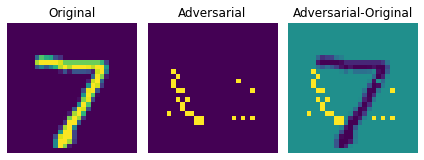

In [60]:
show_images_diff(np.array(X[0]).transpose(1,2,0),adversary.original_label,adv,adversary.adversarial_label)